<a href="https://colab.research.google.com/github/cianryan09/VaR-Calculation/blob/main/PRMIA_Exercise_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Investment_20231229/S&P500_Price_Data_20231229.csv', index_col='date')

In [ ]:
!pip install PyPortfolioOpt

In [ ]:
from pypfopt.expected_returns import mean_historical_return, capm_return, returns_from_prices
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df_bm = df[['Benchmark']]

In [ ]:
!pip install financetoolkit

In [ ]:
from financetoolkit import economics

In [ ]:
f_model = economics.fed_model.get_effective_federal_funds_rate().loc['2023-12-29', 'Rate']
f_model

0.0533

In [ ]:
rf = f_model

mu = capm_return(df, df_bm, risk_free_rate=rf)
S = CovarianceShrinkage(df).ledoit_wolf()

In [ ]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

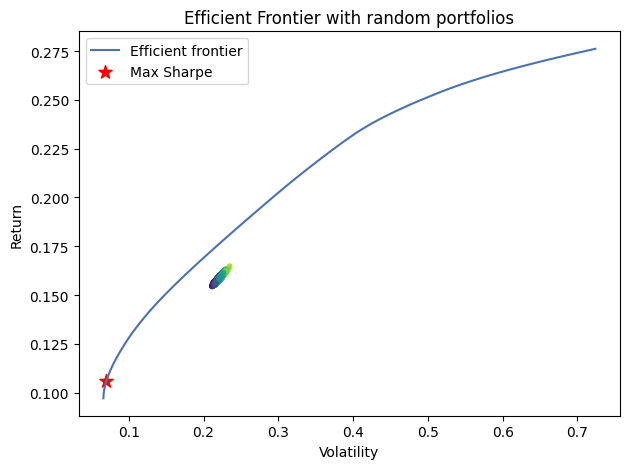

In [ ]:
# Plot efficient frontier with Monte Carlo sim
ef_ = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)

# fig, ax = plt.subplots()
# plotting.plot_efficient_frontier(ef2, ax=ax, show_assets=False)

ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
ef_pp = ef2.portfolio_performance(verbose=True)

Expected annual return: 10.6%
Annual volatility: 7.0%
Sharpe Ratio: 1.23


In [ ]:
# get the weights
cleaned_weights = ef2.clean_weights()
# ef.save_weights_to_file("weights.txt")  # saves to file

cleaned_weights_reduced = {x:y for x,y in cleaned_weights.items() if y!=0}

# tickers
tickers = list(cleaned_weights_reduced.keys())

In [ ]:
# export data for Var Calculations (returns and weights)

df_weights = pd.DataFrame(cleaned_weights_reduced.items(), columns=['Ticker', 'Weight %'])
df_weights.to_csv('PRM weights.csv', index=False)

In [ ]:
df_returns = returns_from_prices(df.loc[:, tickers])
# df_returns
df_returns = df_returns.fillna(0)
df_returns.to_csv('PRM Returns.csv')